In [1]:
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re


from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [2]:
# https://www.kaggle.com/datasets/imsparsh/flowers-dataset
train_path = "flower/train"
test_path = "flower/test"

submission = pd.read_csv("flower\sample_submission.csv")

class_names = os.listdir(train_path)
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [3]:
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(train_path + "/" + i)))

Number of Daisy images: 501
Number of Dandelion images: 646
Number of Rose images: 497
Number of Sunflower images: 495
Number of Tulip images: 607


In [4]:
X = []
y = []

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = imread(image_path) 

        image = cv2.resize(image, (224, 224))
        X.append(image)
        y.append(i)
X = np.array(X)
y = np.array(y)

total test size : 924


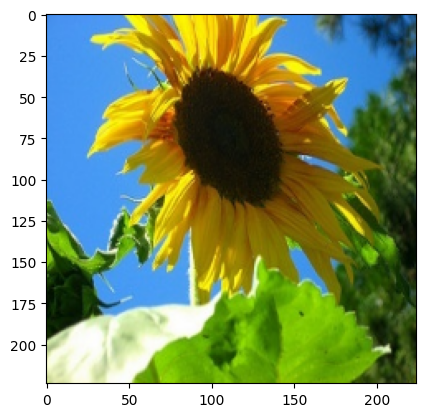

In [5]:
test = []

image_names = os.listdir(test_path)
image_names.sort(key = lambda x: int(re.search(r'Image_(\d+)', x).group(1))) 

for image_name in image_names:
    
    image_path = os.path.join(test_path, image_name) 
    image = imread(image_path)
    image = cv2.resize(image, (224, 224))
    test.append(image)

print("total test size :", len(os.listdir(test_path)))    
plt.imshow(test[0]);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [7]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50

# def construct_PPNet(base_architecture='resnet50', num_classes=5):
#     # Define base architecture
#     if base_architecture == 'resnet50':
#         base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     else:
#         raise ValueError("Unsupported base architecture. Supported options: 'resnet50'")

#     # Add custom classifier layers on top of the base model
#     model = tf.keras.models.Sequential([
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

def construct_PPNet(base_architecture='resnet50', num_classes=5):
    # Define base architecture
    if base_architecture == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Unsupported base architecture. Supported options: 'resnet50'")

    # Add custom classifier layers on top of the base model
    classifier = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the classifier
    classifier.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    # Get the last convolutional layer before global average pooling
    activation_layer = base_model.layers[-2].output
    
    # Create the activation model
    activation_model = tf.keras.models.Model(inputs=base_model.input, outputs=activation_layer)

    return classifier, activation_model


In [9]:
optimizer = Adam(learning_rate = 0.001)

classifier_model, activation_model = construct_PPNet(base_architecture='resnet50', num_classes=5)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

In [10]:
# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Train the model
history = classifier_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on test data
test_loss, test_accuracy = classifier_model.evaluate(X_test, y_test, verbose=0)

# Calculate F1 score
from sklearn.metrics import f1_score
y_pred = classifier_model.predict(X_test)
f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)
print("F1 Score:", f1)


Epoch 1/10
69/69 [==============================] - 591s 8s/step - loss: 1.1524 - accuracy: 0.6457 - val_loss: 27909.1270 - val_accuracy: 0.1800
Epoch 2/10
69/69 [==============================] - 580s 8s/step - loss: 0.6225 - accuracy: 0.7805 - val_loss: 7.0355 - val_accuracy: 0.3782
Epoch 3/10
69/69 [==============================] - 580s 8s/step - loss: 0.4084 - accuracy: 0.8511 - val_loss: 2.2709 - val_accuracy: 0.6091
Epoch 4/10
69/69 [==============================] - 590s 9s/step - loss: 0.3219 - accuracy: 0.8907 - val_loss: 0.7350 - val_accuracy: 0.7636
Epoch 5/10
69/69 [==============================] - 575s 8s/step - loss: 0.2479 - accuracy: 0.9208 - val_loss: 0.6694 - val_accuracy: 0.8182
Epoch 6/10
69/69 [==============================] - 576s 8s/step - loss: 0.2386 - accuracy: 0.9148 - val_loss: 0.6443 - val_accuracy: 0.7909
Epoch 7/10
69/69 [==============================] - 577s 8s/step - loss: 0.1540 - accuracy: 0.9490 - val_loss: 0.6867 - val_accuracy: 0.7545
Epoch 8/1

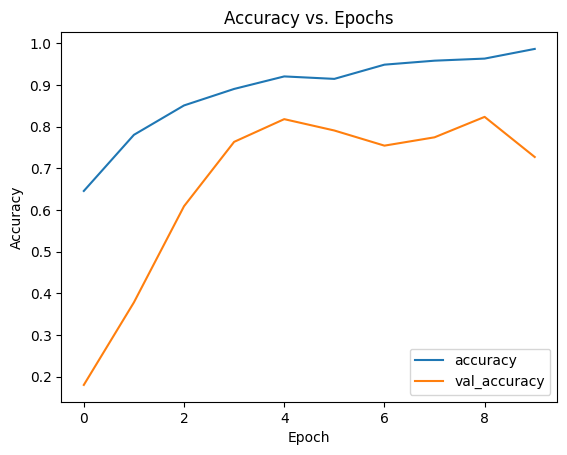

In [11]:
import matplotlib.pyplot as plt

# Plot training history for accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy vs. Epochs')
plt.show()


In [12]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50

# def construct_PPNet(base_architecture='resnet50', num_classes=5):
#     # Define base architecture
#     if base_architecture == 'resnet50':
#         base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     else:
#         raise ValueError("Unsupported base architecture. Supported options: 'resnet50'")

#     # Add custom classifier layers on top of the base model
#     classifier = tf.keras.models.Sequential([
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     # Compile the classifier
#     classifier.compile(optimizer='adam',
#                        loss='sparse_categorical_crossentropy',
#                        metrics=['accuracy'])

#     # Get the last convolutional layer before global average pooling
#     activation_layer = base_model.layers[-2].output
    
#     # Create the activation model
#     activation_model = tf.keras.models.Model(inputs=base_model.input, outputs=activation_layer)

#     return classifier, activation_model

# # Example usage:
# classifier_model, activation_model = construct_PPNet(base_architecture='resnet50', num_classes=5)

# # Now you can use classifier_model for training and evaluation,
# # and activation_model for visualizing activations.


1/1 [==============================] - 0s 148ms/step


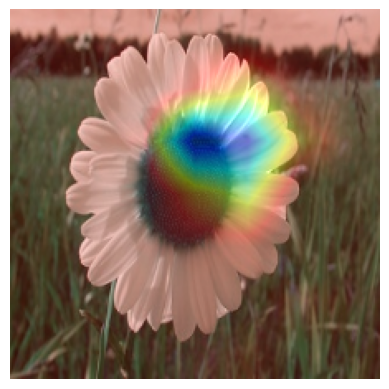

In [31]:

# Load an image
image_path = "flower/test/Image_888.jpg"  # Change this to the path of your image

# Check if the image file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file '{image_path}' not found.")

# Read the image
image = cv2.imread(image_path)

# Check if the image is loaded successfully
if image is None:
    raise ValueError(f"Failed to load image from '{image_path}'.")

# Resize the image to match the input size of the model
image = cv2.resize(image, (224, 224))

# Preprocess the image (if necessary)
# Note: If your construct_PPNet function includes preprocessing, you may skip this step

# Obtain the activation map for the image
activation_map = activation_model.predict(np.expand_dims(image, axis=0))

# Get the weights of the output layer
class_weights = classifier_model.layers[-1].get_weights()[0][:, np.argmax(classifier_model.predict(np.expand_dims(image, axis=0)))]

# Compute the CAM by taking dot product of activation map and class weights
cam = np.dot(activation_map.squeeze(), class_weights)

# Resize and normalize the CAM
cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
cam = cam / np.max(cam)

# Apply colormap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
overlaid_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

# Display the overlaid image
plt.imshow(overlaid_image)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 118ms/step


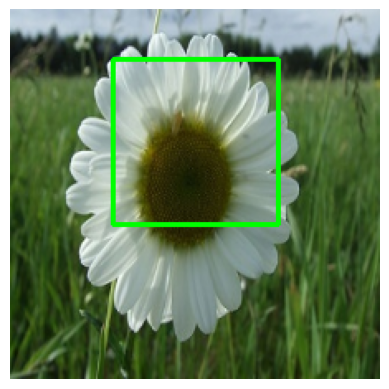

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image_path = "flower/test/Image_888.jpg"  # Change this to the path of your image
image = cv2.imread(image_path)

# Check if the image is loaded successfully
if image is None:
    raise ValueError(f"Failed to load image from '{image_path}'.")

# Resize the image to match the input size of the model
image_resized = cv2.resize(image, (224, 224))

# Preprocess the image (if necessary)
# Note: If your construct_PPNet function includes preprocessing, you may skip this step

# Obtain the activation map for the image
activation_map = activation_model.predict(np.expand_dims(image_resized, axis=0))

# Get the weights of the output layer
class_weights = classifier_model.layers[-1].get_weights()[0][:, np.argmax(classifier_model.predict(np.expand_dims(image_resized, axis=0)))]

# Compute the CAM by taking dot product of activation map and class weights
cam = np.dot(activation_map.squeeze(), class_weights)

# Resize and normalize the CAM
cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
cam = cam / np.max(cam)

# Find the coordinates of the pixel with maximum activation
max_row, max_col = np.unravel_index(cam.argmax(), cam.shape)

# Define the size of the square
square_size = 100

# Calculate the coordinates of the square
top_left = (max_col - square_size // 2, max_row - square_size // 2)
bottom_right = (max_col + square_size // 2, max_row + square_size // 2)

# Draw a square around the most important part of the image
image_with_square = cv2.rectangle(image_resized.copy(), top_left, bottom_right, (0, 255, 0), 2)

# Display the image with the square
plt.imshow(cv2.cvtColor(image_with_square, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
